In [473]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
import numpy as np
import time
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [474]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_validate = x_test[:100]

In [475]:
def relu_grad(x):
    return tf.where(tf.less(x, 0), tf.zeros_like(x), tf.ones_like(x))

In [552]:
class Autoencoder(object):
    def __init__(self, input_shape = (28,28), ngd=False):
        self.model = tf.keras.Sequential([
          layers.InputLayer(input_shape),
          layers.Flatten(name="x0"),
          layers.Dense(512, use_bias=False, name="pre_x1"),
          layers.Activation("relu", name="x1"),
          layers.Dense(256, use_bias=False, name="pre_x2"),
          layers.Activation("relu", name="x2"),
          layers.Dense(128, use_bias=False, name="pre_x3"),
          layers.Activation("relu", name="x3"),
          layers.Dense(64, use_bias=False, name="pre_x4"),
          layers.Activation("relu", name="x4"),
          layers.Dense(32, use_bias=False, name="pre_x5"),
          layers.Activation("relu", name="x5"), # latent representation
          layers.Dense(64, use_bias=False, name="pre_x6"),
          layers.Activation("relu", name="x6"),
          layers.Dense(128, use_bias=False, name="pre_x7"),
          layers.Activation("relu", name="x7"),
          layers.Dense(256, use_bias=False, name="pre_x8"),
          layers.Activation("relu", name="x8"),
          layers.Dense(512, use_bias=False, name="pre_x9"),
          layers.Activation("relu", name="x9"),
          layers.Dense(784, use_bias=False, name="pre_x10"),
          layers.Activation("relu", name="x10"),
          layers.Reshape((28, 28))
        ])
        outputs = []
        pre_outputs = []
        for layer in self.model.layers:
            if layer.name[0] == 'x':
                outputs.append(layer.output)
            elif layer.name[0:3] == "pre":
                pre_outputs.append(layer.output)
        self.extend_model = tf.keras.Model(self.model.input, [self.model.output, outputs, pre_outputs])
        self.dtype = tf.float32
        self.ngd = ngd
        self.sigma = 1e-6
        self.training_error = []
        self.time_stamps = []
        self.save_path = None
        
    def __loss(self, x_input):
        outputs = self.extend_model(x_input)
        loss = losses.MeanSquaredError()(x_input, outputs[0])
        self.x = outputs[1]
        self.pre_x = outputs[2]
        return loss
    
    def __grad(self, x_input):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(x_input)
        grad = tape.gradient(loss_value, self.__wrap_training_variables())
        
        if self.ngd:
            L = len(self.x) - 1
            self.e = []
            dist = tfp.distributions.Normal(loc=0., scale=self.sigma)
            pre_x_reverse = self.pre_x[::-1]
            pre_output_layers = []
            for layer in self.model.layers:
                if layer.name[0:3] == "pre":
                    pre_output_layers.append(layer)
            self.e.append(relu_grad(pre_x_reverse[0]) * dist.sample(self.x[-1].shape) / x_input.shape[0] * 2)
            for i, layer in enumerate(pre_output_layers[::-1][:-1]): # in a reverse order
                new_e = relu_grad(pre_x_reverse[i+1]) * tf.matmul(self.e[-1], tf.transpose(layer.kernel))
                self.e.append(new_e)
            self.e.append(None)
            self.e = self.e[::-1]
            for i, layer in enumerate(pre_output_layers):
                right = tf.tensordot(self.e[i+1], self.e[i+1], axes=[[0], [0]]) / x_input.shape[0]
                left = tf.tensordot(self.x[i], self.x[i], axes=[[0], [0]]) / x_input.shape[0]
                left_inverse = tf.linalg.inv(left + 1e-5 * tf.eye(left.shape[0]));
                right_inverse = tf.linalg.inv(right + 1e-5 * tf.eye(right.shape[0]))
                grad[i] = 1 / L * tf.linalg.matmul(tf.linalg.matmul(left_inverse, grad[i]), right_inverse)
        return loss_value, grad
    
    def __wrap_training_variables(self):
        var = self.model.trainable_variables
        return var

    def summary(self):
        self.model.summary()
        
    # The training function
    def fit(self, x_train, x_validate, tf_optimizer, tf_epochs=5000, batch_size=1024, shuffle_buffer_size=10 * 1024, save_frequency = 10):
        train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
        train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
        validate_data = tf.convert_to_tensor(x_validate, dtype='float32')
        t = time.time()
        for epoch in range(tf_epochs):
            # Optimization step
            for data in train_dataset:
                loss_value, grads = self.__grad(data)
                elapsed = time.time() - t
                self.training_error.append(loss_value)
                self.time_stamps.append(elapsed)
                tf_optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
            if (epoch % 5 == 0):
                if (self.save_path != None):
                    self.model.save('outputs/'+ self.save_path + 'epoch_' +str(epoch) +'.h5')
            print(f"epoch: {epoch}, loss_value: {self.__loss(x_validate)}")

In [521]:
net2 = Autoencoder(ngd=False)
# net2.summary()

In [ ]:
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=5e-1,
  beta_1=0.99,
  epsilon=1e-1)
net2.save_path = 'SGD'
net2.fit(x_train, x_validate, tf_optimizer, 1000, )

In [528]:
np.save('SGD_error.npy', net2.training_error)
np.save('SGD_timestamp.npy', net2.time_stamps)

In [559]:
net1 = Autoencoder(ngd=True)
# net1.summary()

In [560]:
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=1e-3,
  beta_1=0.99,
  epsilon=1e-1)
net1.save_path = 'NGD'
net1.fit(x_train, x_validate, tf_optimizer, 200)
np.save('NGD_error.npy', net1.training_error)
np.save('NGD_timestamp.npy', net1.time_stamps)

epoch: 0, loss_value: 0.0760689377784729
epoch: 1, loss_value: 0.06439995765686035
epoch: 2, loss_value: 0.05742203816771507
epoch: 3, loss_value: 0.052303753793239594
epoch: 4, loss_value: 0.04728595167398453
epoch: 5, loss_value: 0.043406855314970016
epoch: 6, loss_value: 0.03969995677471161
epoch: 7, loss_value: 0.03632572293281555
epoch: 8, loss_value: 0.0336686410009861
epoch: 9, loss_value: 0.031110938638448715
epoch: 10, loss_value: 0.02884681709110737
epoch: 11, loss_value: 0.02676517516374588
epoch: 12, loss_value: 0.02497088350355625
epoch: 13, loss_value: 0.023364532738924026
epoch: 14, loss_value: 0.021876530721783638
epoch: 15, loss_value: 0.020545439794659615
epoch: 16, loss_value: 0.019325947389006615
epoch: 17, loss_value: 0.018254511058330536
epoch: 18, loss_value: 0.017223762348294258
epoch: 19, loss_value: 0.016285870224237442
epoch: 20, loss_value: 0.015594294294714928
epoch: 21, loss_value: 0.015031528659164906
epoch: 22, loss_value: 0.014505677856504917
epoch: 23,

In [ ]:
np.save('net1_error.npy', np.log(net1.training_error))
b = np.load('net1_error.npy')
print(b)
model3 = tf.keras.models.load_model('outputs/model0.h5')
model3.summary()

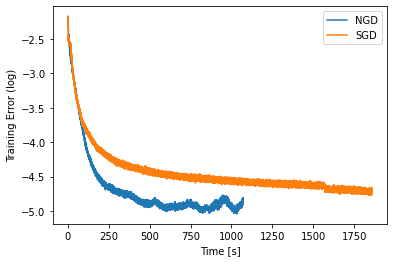

In [573]:
import matplotlib.pyplot as plt
plt.plot(net1.time_stamps, np.log(net1.training_error))
plt.plot(net2.time_stamps, np.log(net2.training_error))
# plt.xlim([-50, 850])
plt.legend(["NGD", "SGD"])
plt.ylabel("Training Error (log)")
plt.xlabel("Time [s]")
plt.savefig("loss-time.pdf", dpi=600, bbox_inches="tight")

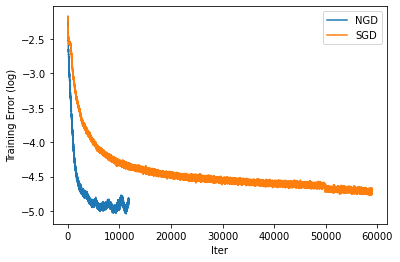

In [574]:
plt.plot(range(len(net1.training_error)), np.log(net1.training_error))
plt.plot(range(len(net2.training_error)), np.log(net2.training_error))
plt.legend(["NGD", "SGD"])
plt.ylabel("Training Error (log)")
plt.xlabel("Iter")
plt.savefig("loss-iter.pdf", dpi=600, bbox_inches="tight")

In [578]:
net2.training_error[59 * 110]

<tf.Tensor: shape=(), dtype=float32, numpy=0.016150309>

In [579]:
net1.training_error[59*110]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0070094145>

In [580]:
net1.summary()

Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Flatten)                (None, 784)               0         
                                                                 
 pre_x1 (Dense)              (None, 512)               401408    
                                                                 
 x1 (Activation)             (None, 512)               0         
                                                                 
 pre_x2 (Dense)              (None, 256)               131072    
                                                                 
 x2 (Activation)             (None, 256)               0         
                                                                 
 pre_x3 (Dense)              (None, 128)               32768     
                                                                 
 x3 (Activation)             (None, 128)            